*Installing the Libraries*


In [37]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
Input_path = 'D:\Project\AI_ML_Projects\EMG Classification\dataset\EMG-data.csv'
df = pd.read_csv(Input_path)
print(df.head())
print(df.shape)

   time  channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0     1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1     5   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2     6  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3     7  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4     8  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  class  label  
0  -0.00001      0      1  
1  -0.00001      0      1  
2   0.00001      0      1  
3   0.00001      0      1  
4   0.00001      0      1  
(4237907, 11)


In [5]:
print("class :", df["class"].unique())
print()
print("Labels :",df["label"].unique()) # 36 people hand gesture data
print()
print("Value Count :\n",df["class"].value_counts())

class : [0 1 2 3 4 5 6 7]

Labels : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]

Value Count :
 class
0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: count, dtype: int64


In [6]:
features = df.drop(columns=["label","class","time"])
display(features.head())

channel1  channel2  channel3  channel4  channel5  channel6  channel7  \
0   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
1   0.00001  -0.00002  -0.00001  -0.00003   0.00000  -0.00001   0.00000   
2  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
3  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   
4  -0.00001   0.00001   0.00002   0.00000   0.00001  -0.00002  -0.00001   

   channel8  
0  -0.00001  
1  -0.00001  
2   0.00001  
3   0.00001  
4   0.00001

In [7]:
import numpy as np

# Assuming 'emg_data' is your NumPy array or DataFrame
mean = 0
std_dev = 0.1 * np.std(features)  # Adjust 0.1 as needed

noise = np.random.normal(mean, std_dev, features.shape)
emg_data_fatigue = features + noise

df_noisy = pd.concat(
    [df[['time', 'class', 'label']].reset_index(drop=True),
     pd.DataFrame(emg_data_fatigue, columns=features.columns).reset_index(drop=True)],
    axis=1
)

c:\Users\owais\anaconda3\Lib\site-packages\numpy\_core\fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [8]:
df_noisy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237907 entries, 0 to 4237906
Data columns (total 11 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      int64  
 1   class     int64  
 2   label     int64  
 3   channel1  float64
 4   channel2  float64
 5   channel3  float64
 6   channel4  float64
 7   channel5  float64
 8   channel6  float64
 9   channel7  float64
 10  channel8  float64
dtypes: float64(8), int64(3)
memory usage: 355.7 MB


In [9]:
df_noisy.shape

(4237907, 11)

In [10]:
# Compute the time differences
time_diff = df['time'].diff().dropna()

# Compute the sample rate (1 / average time difference)
sample_rate = 1 / time_diff.mean()
print(f"Estimated Sample Rate: {sample_rate:.2f} Hz")


Estimated Sample Rate: 83.15 Hz


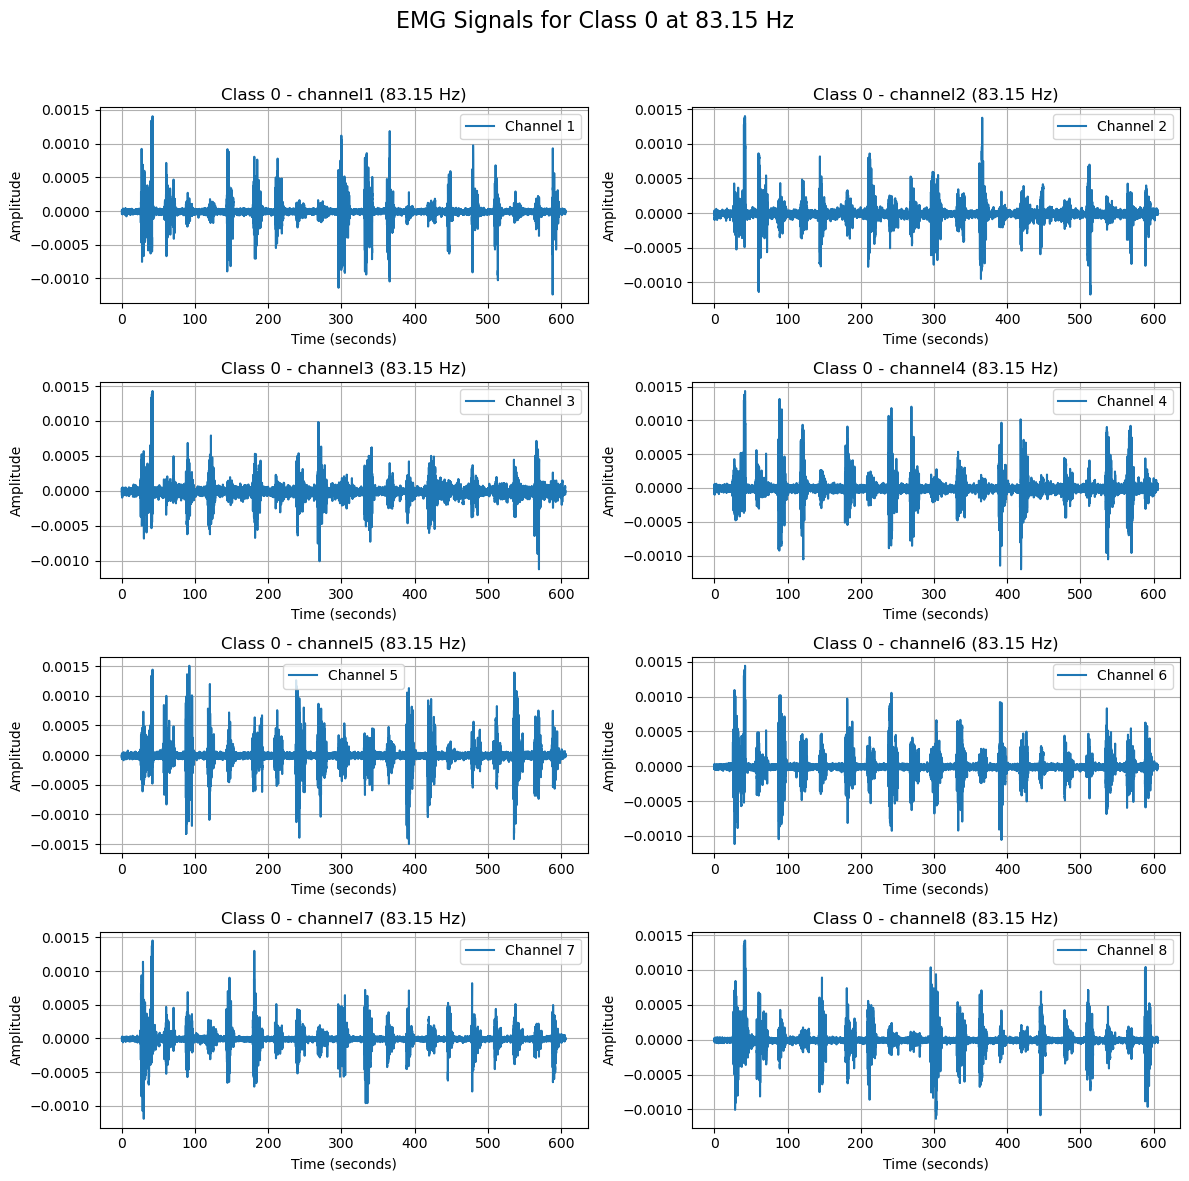

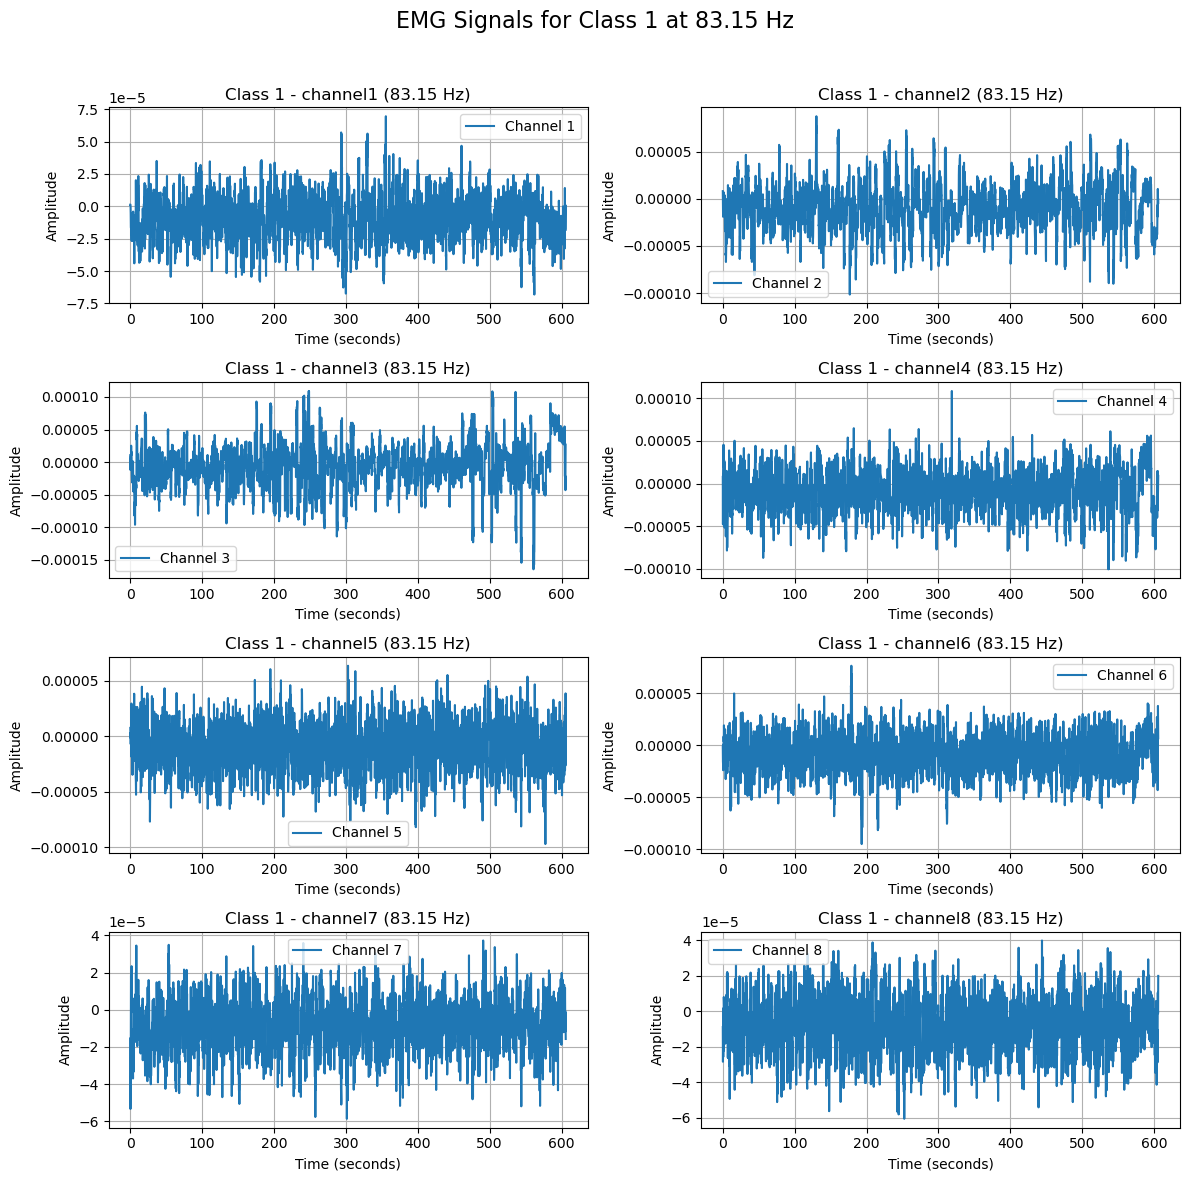

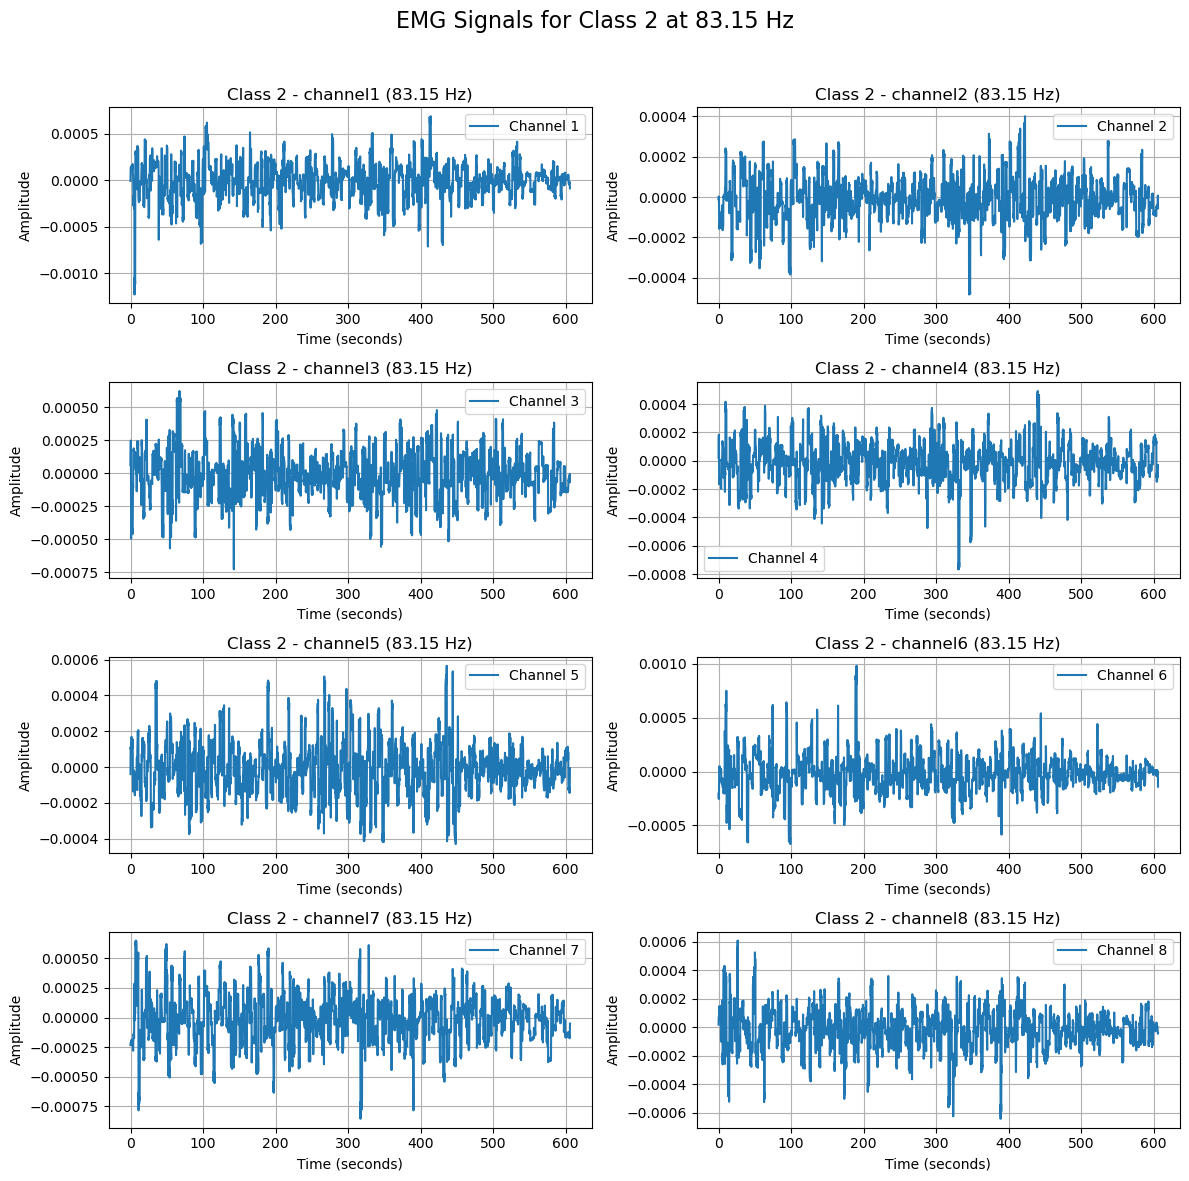

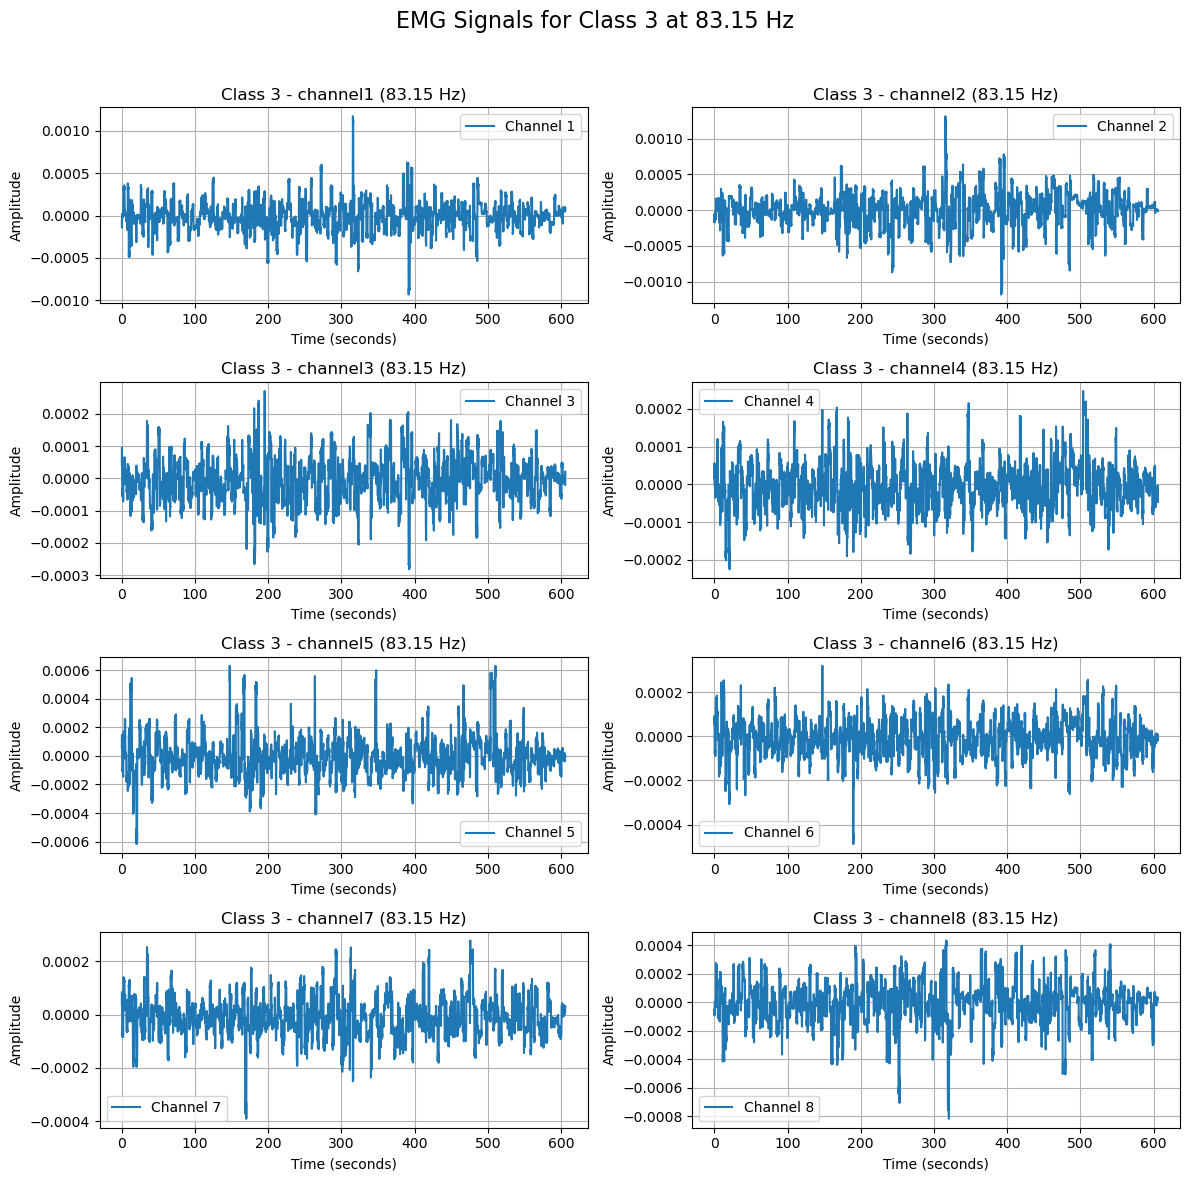

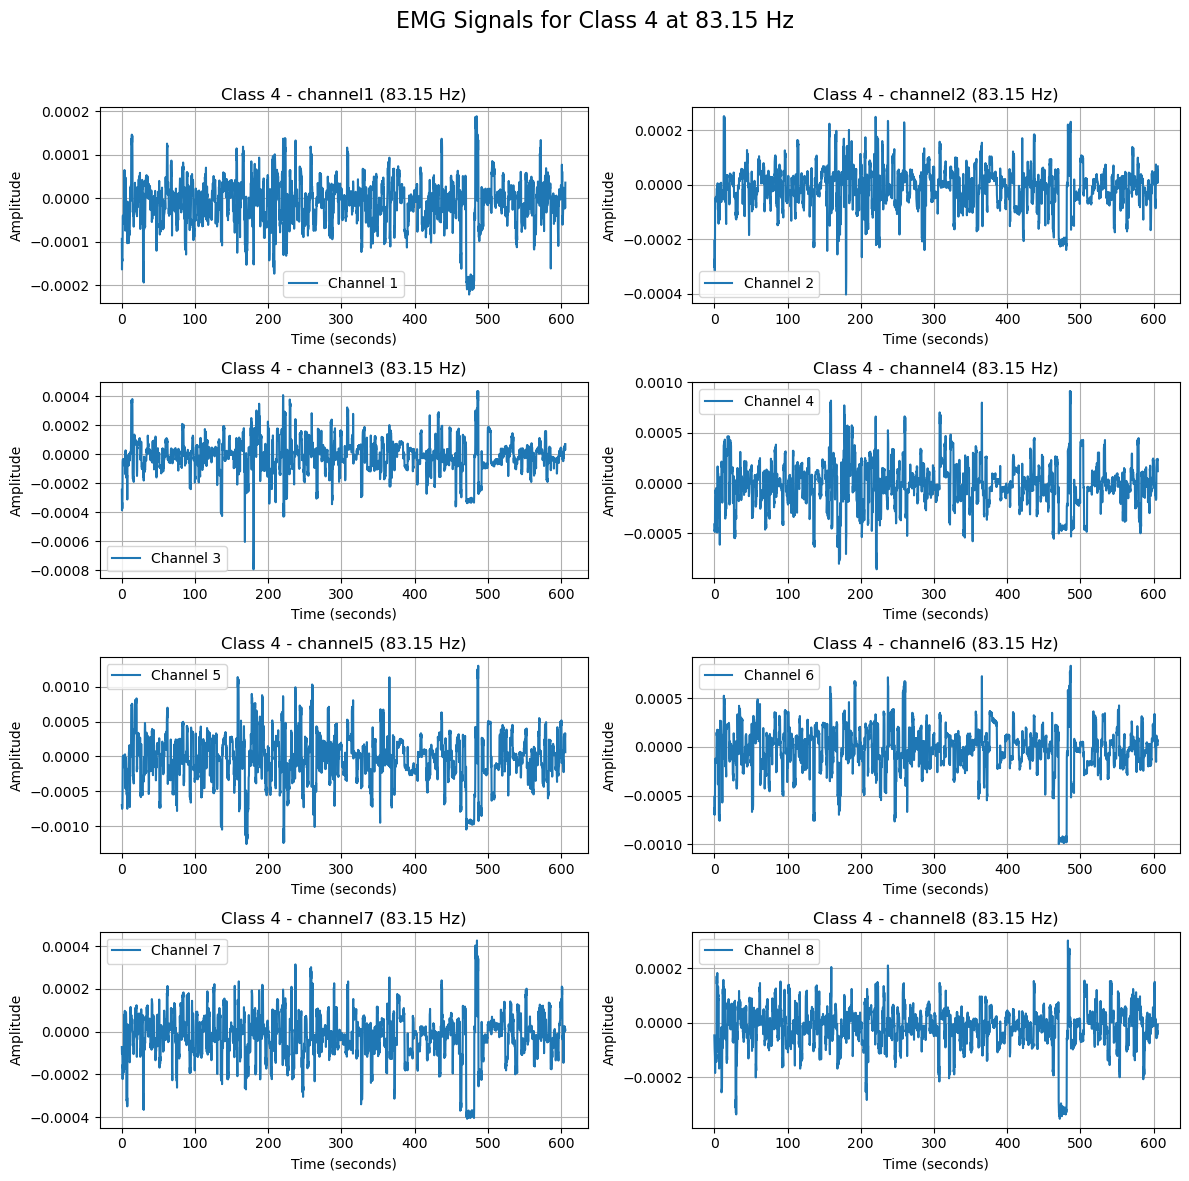

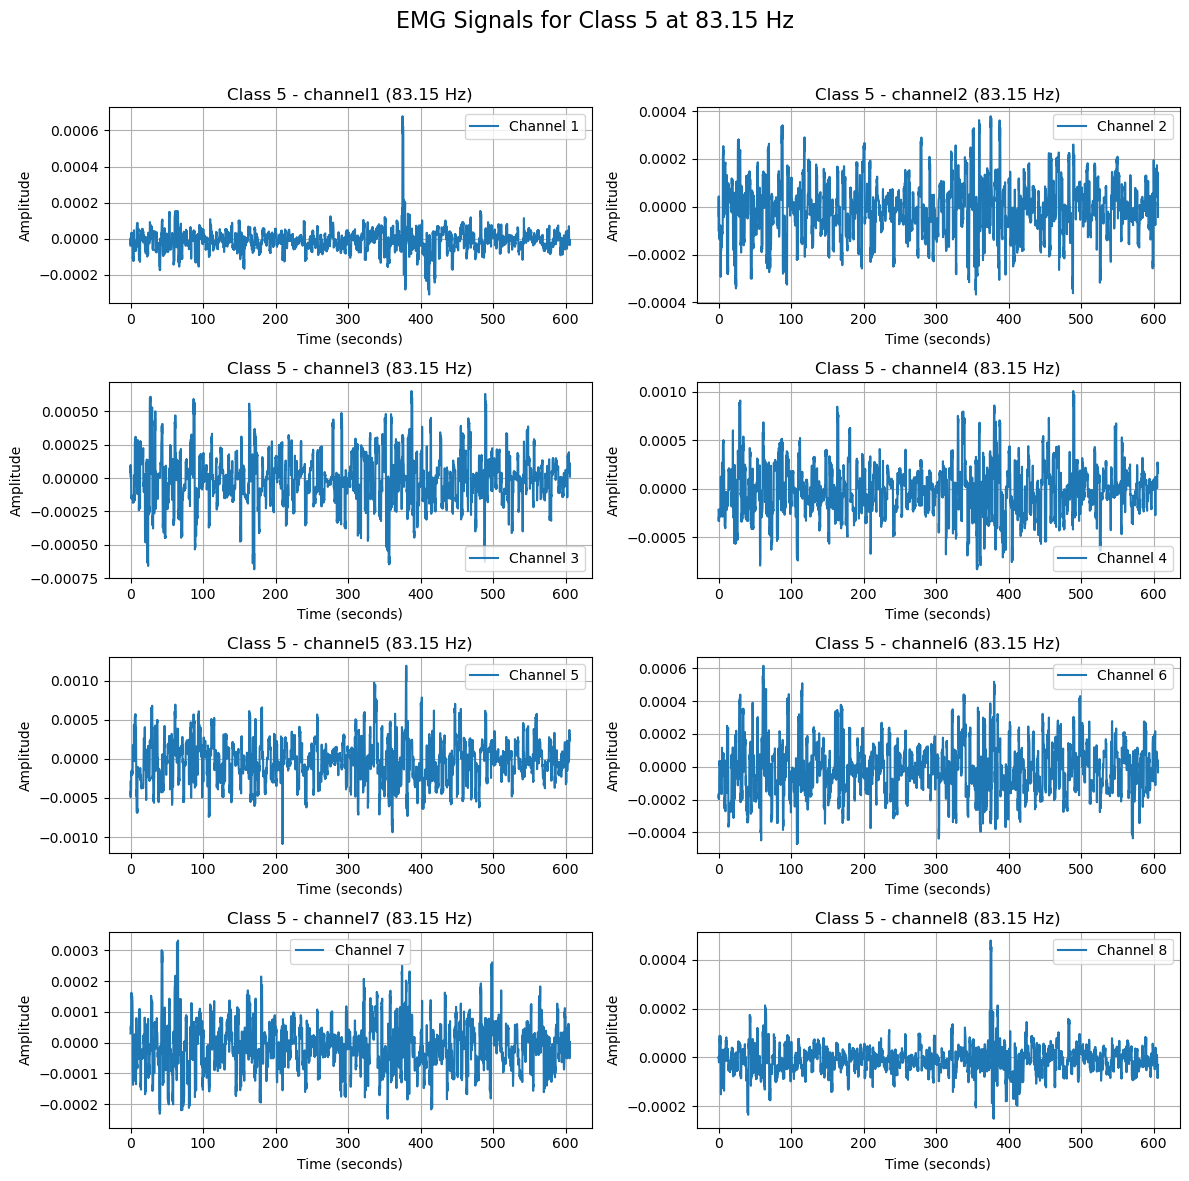

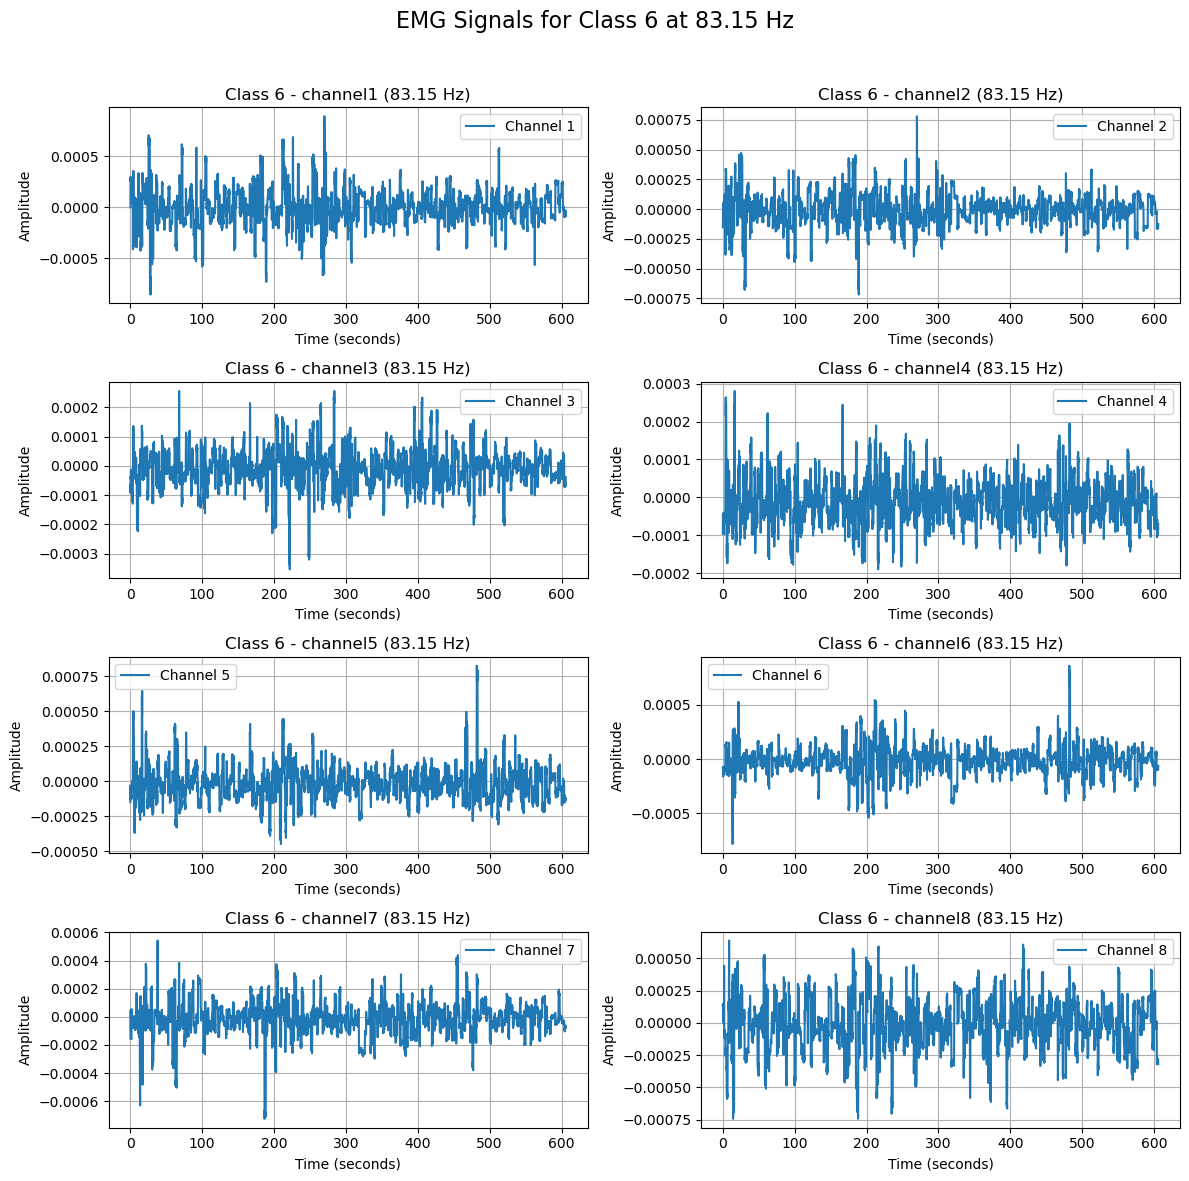

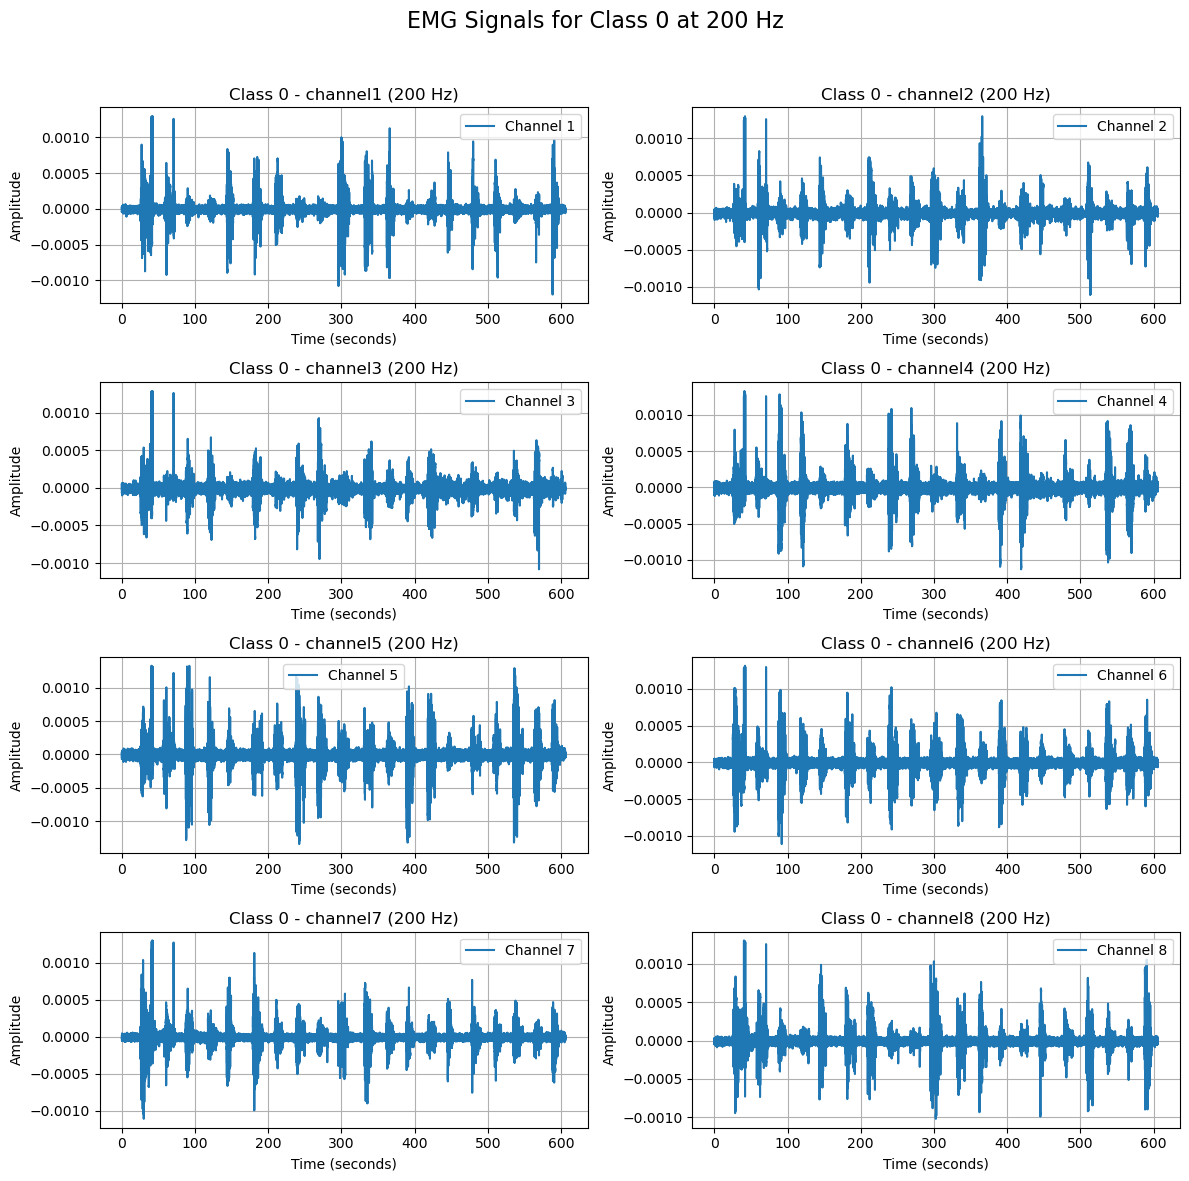

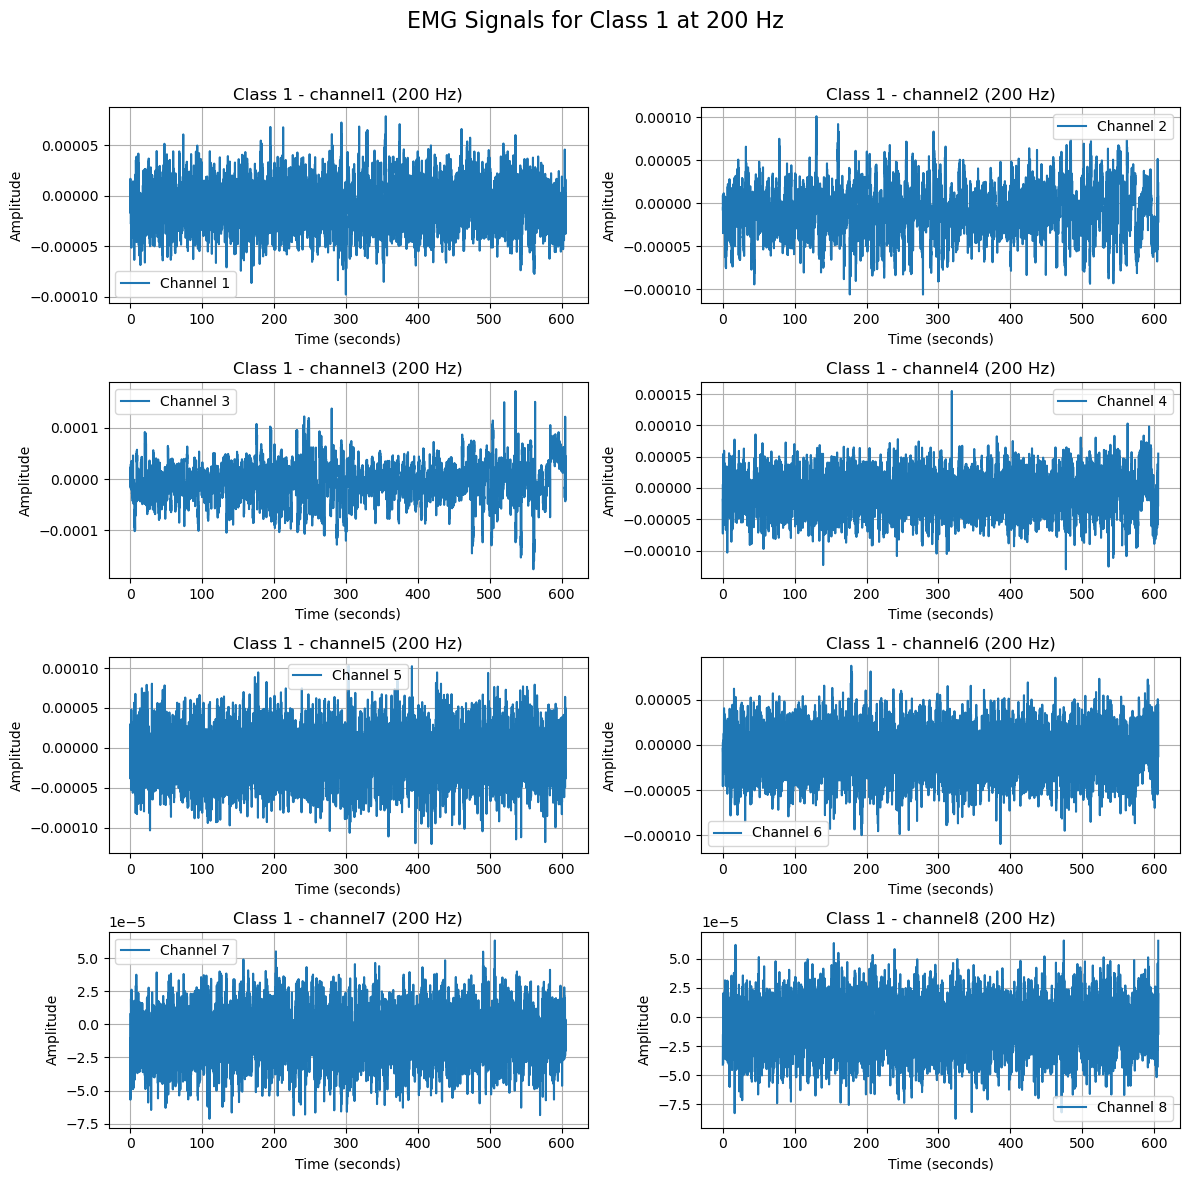

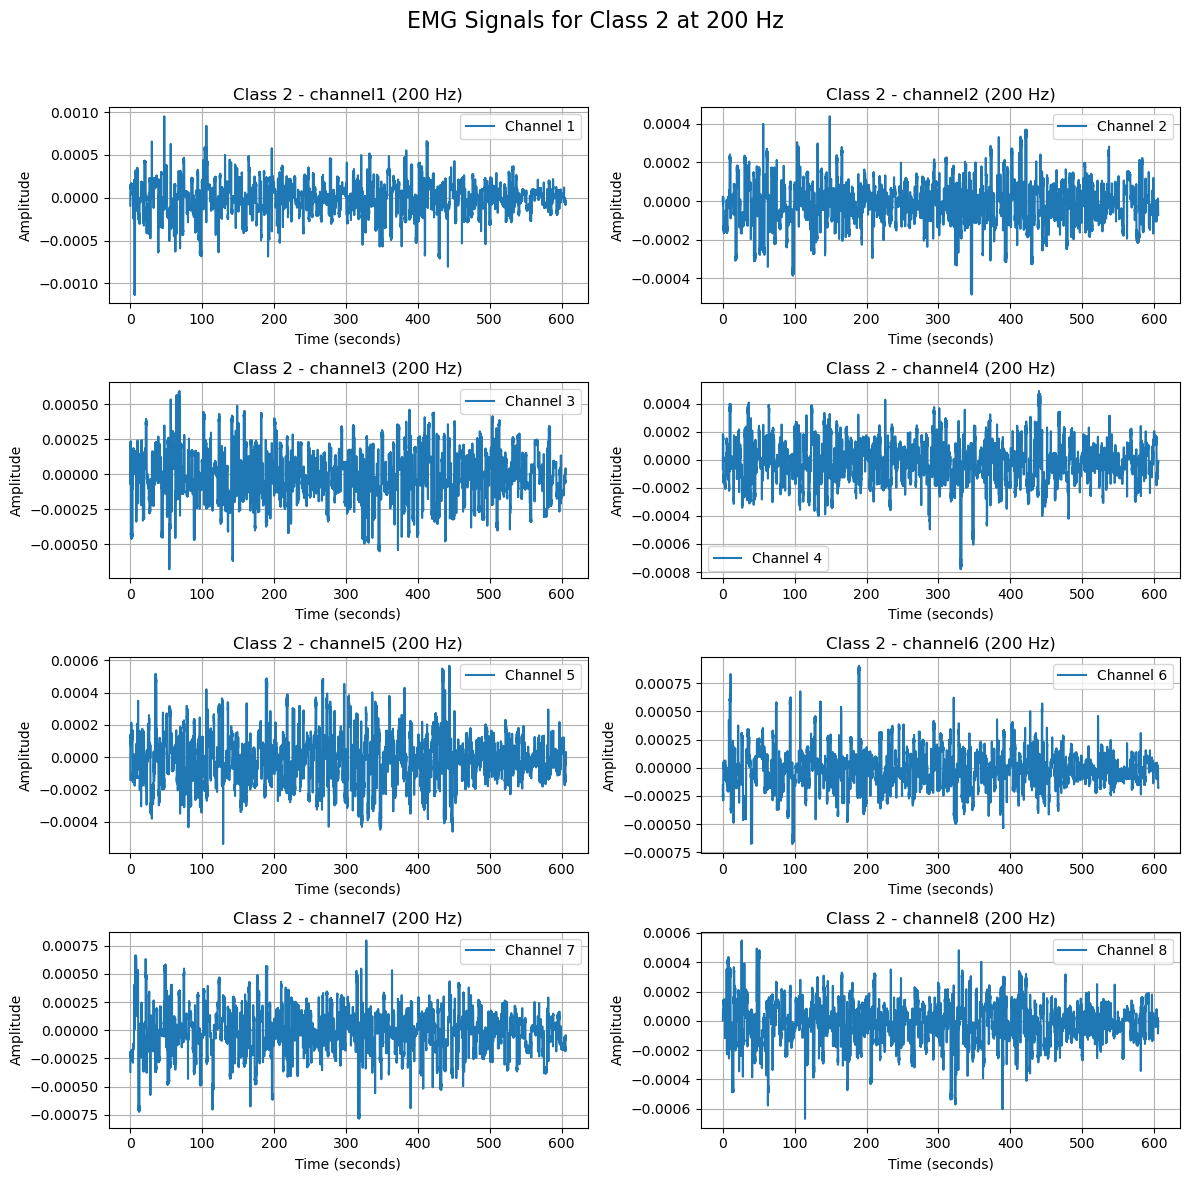

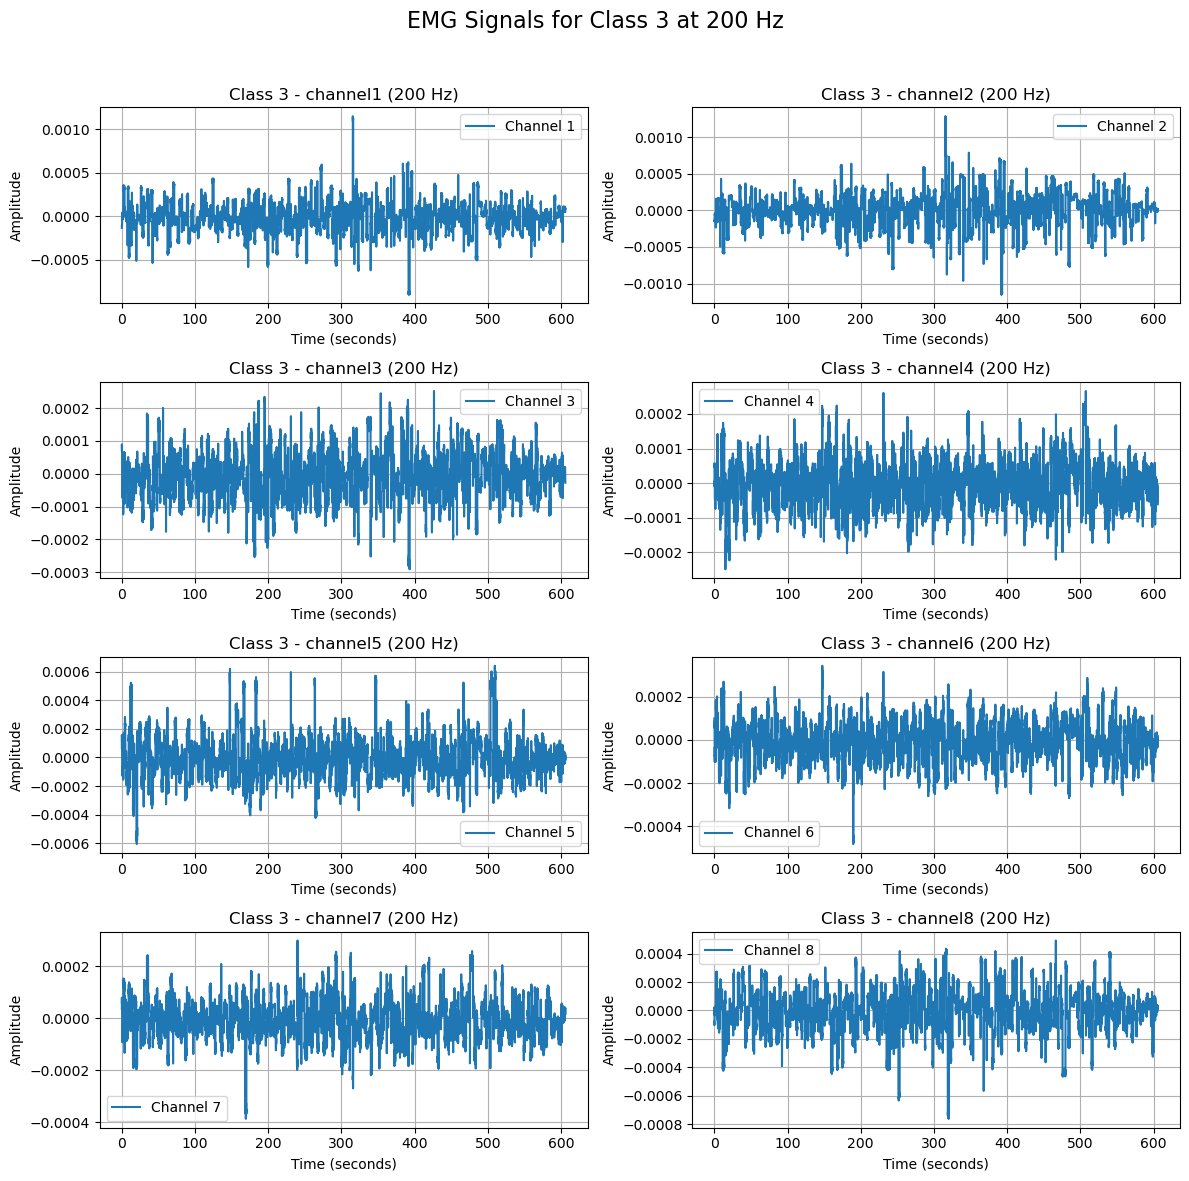

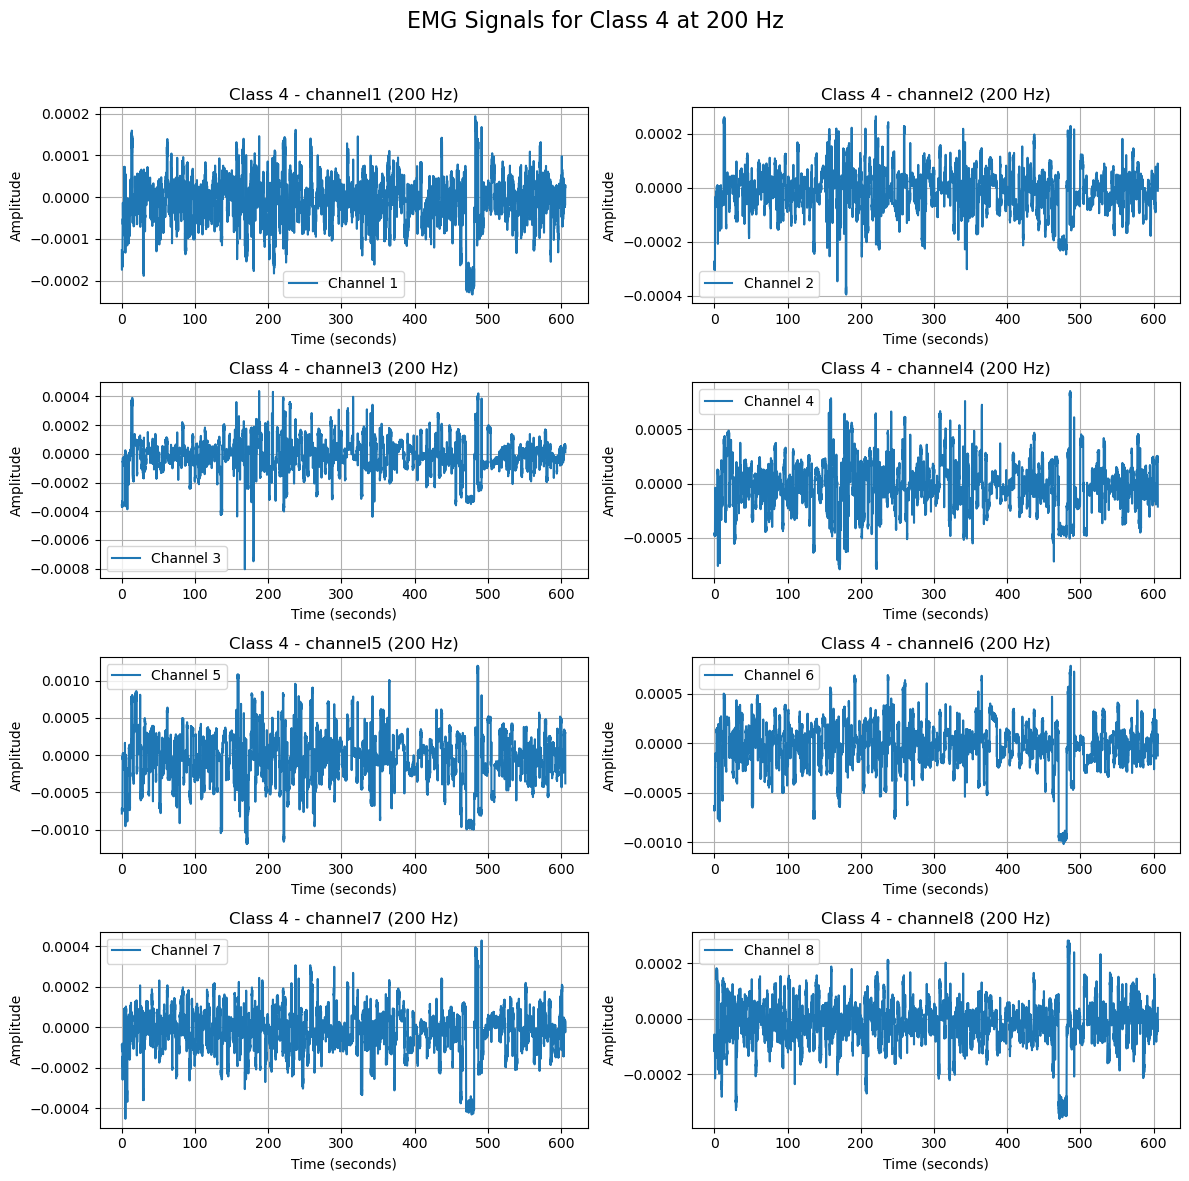

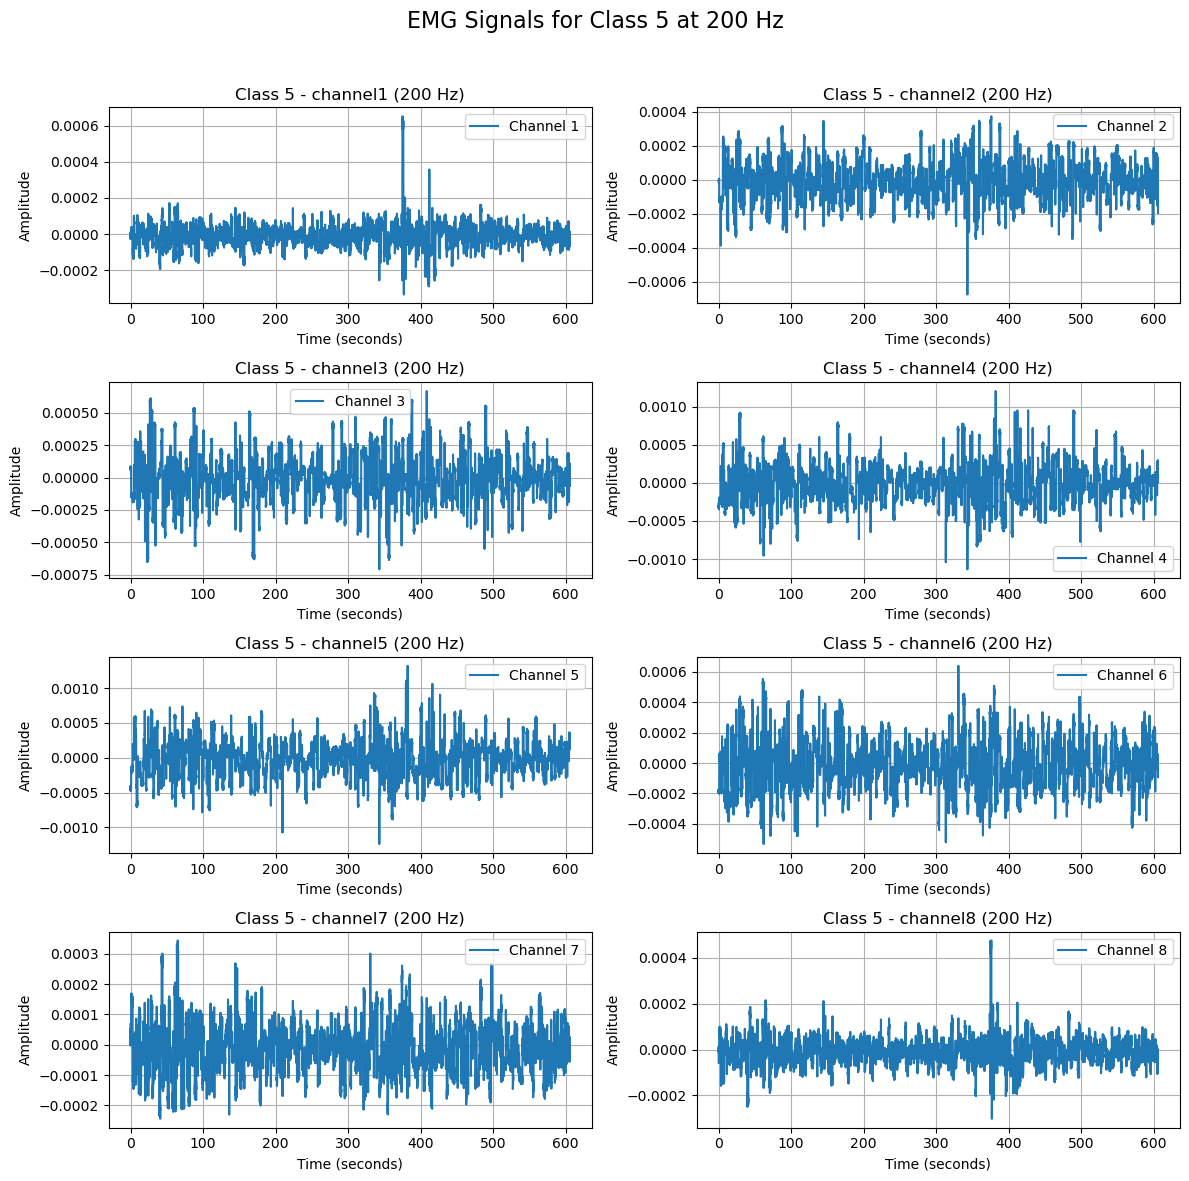

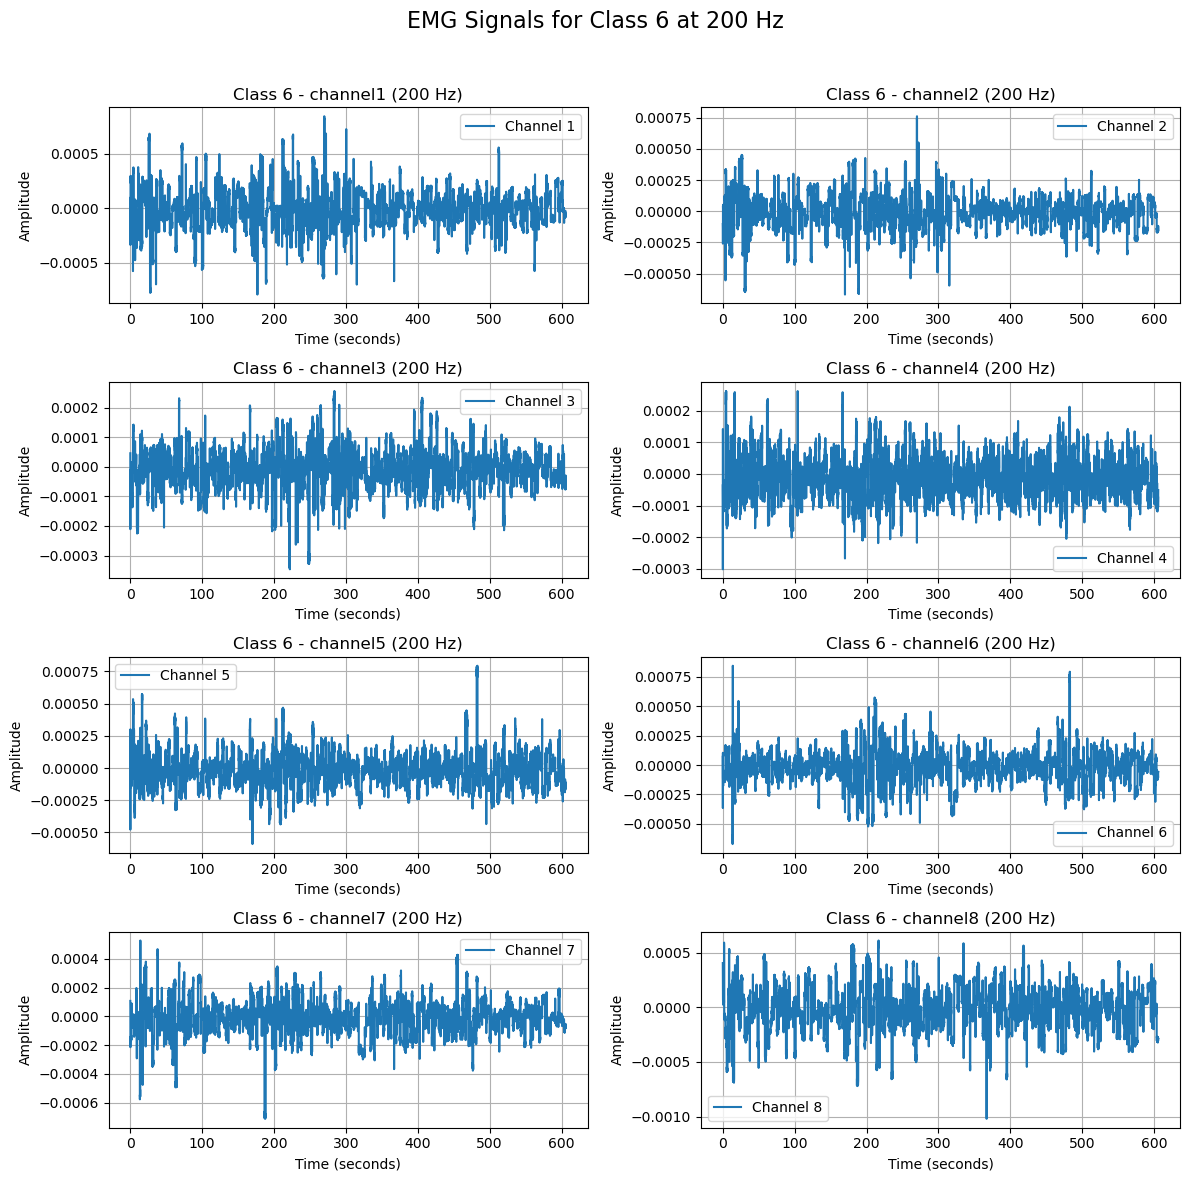

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import resample

# Define channels and sampling rates
emg_channels = [f'channel{i}' for i in range(1, 9)]
original_sample_rate = 200  # Assuming original sample rate is 200 Hz
target_sample_rates = [83.15, 200]  # Resample to both 83.15 Hz and 200 Hz

# Filter data for label 1
df_label1 = df_noisy[df_noisy['label'] == 1]

# Time vector for the original signal
time_original = np.arange(len(df_label1)) / original_sample_rate

# Loop over target sample rates
for sample_rate in target_sample_rates:
    # Loop over each class (0 to 7)
    for class_id in range(8):
        # Filter data for the specific class
        class_data = df_label1[df_label1['class'] == class_id]

        if class_data.empty:
            continue  # Skip if no data for this class

        plt.figure(figsize=(12, 12))

        # Resampling factor
        num_samples = int(len(class_data) * (sample_rate / original_sample_rate))

        for i, channel in enumerate(emg_channels, start=1):
            # Extract original signal
            signal_original = class_data[channel].values

            # Resample signal and time
            signal_resampled = resample(signal_original, num_samples)
            time_resampled = np.linspace(time_original[0], time_original[-1], num_samples)

            # Create subplot
            plt.subplot(4, 2, i)
            plt.plot(time_resampled, signal_resampled, label=f'Channel {i}')
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude")
            plt.title(f"Class {class_id} - {channel} ({sample_rate} Hz)")
            plt.legend()
            plt.grid(True)

        plt.suptitle(f"EMG Signals for Class {class_id} at {sample_rate} Hz", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
        plt.show()

In [12]:
dataset=df_noisy
print(dataset.shape)
##check for any null/empty values
print("\nempty values:",dataset.isnull().any().sum())

(4237907, 11)

empty values: 0


In [13]:
dataset=dataset.drop(columns=["time"])
Class = dataset["class"]
print(Class.unique())
print("Value Count :\n", dataset["class"].value_counts())

[0 1 2 3 4 5 6 7]
Value Count :
 class
0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: count, dtype: int64


In [14]:
##drop gesture 0 because it offers no information due to its unmarked nature
index_numbers_1=dataset[dataset["class"]==0].index
dataset.drop(index_numbers_1,inplace=True)
##drop gesture 7 because it offers no information due to it being performed
##by just two out of 36 patients
index_numbers_2=dataset[dataset["class"]==7].index
dataset.drop(index_numbers_2,inplace=True)

In [15]:
dataset=dataset.groupby(['label','class'])

In [16]:
##functions for extracting sEMG features
def rms(data): ##root mean square
      return  np.sqrt(np.mean(data**2,axis=0))

def SSI(data): ##Simple Square Integral
    return np.sum(data**2,axis=0)

def abs_diffs_signal(data): ##absolute differential signal
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

##function for returning an estimator class name
def print_estimator_name(estimator):
    return estimator.__class__.__name__

In [17]:
##tabulating the aggregated sEMG features
dataset=dataset.agg(['min','max',rms,SSI,abs_diffs_signal,np.ptp])

In [18]:
dataset=dataset.reset_index()
dataset.head()

label class  channel1                                                 \
                    min       max       rms       SSI abs_diffs_signal   
0     1     1 -0.000098  0.000079  0.000023  0.000004         0.140793   
1     1     2 -0.001131  0.000953  0.000211  0.000302         0.281179   
2     1     3 -0.000896  0.001147  0.000189  0.000262         0.269604   
3     1     4 -0.000233  0.000193  0.000059  0.000023         0.149942   
4     1     5 -0.000334  0.000651  0.000068  0.000033         0.166876   

             channel2            ...  channel7                             \
        ptp       min       max  ...       rms       SSI abs_diffs_signal   
0  0.000177 -0.000106  0.000101  ...  0.000020  0.000003         0.131001   
1  0.002084 -0.000484  0.000439  ...  0.000217  0.000319         0.269350   
2  0.002043 -0.001150  0.001286  ...  0.000079  0.000046         0.171849   
3  0.000427 -0.000395  0.000265  ...  0.000119  0.000097         0.182996   
4  0.000985 -0.000675  0.000375  ...  0.000085  0.000051         0.178259   

             channel8                                                           
        ptp       min       max       rms       SSI abs_diffs_signal       ptp  
0  0.000135 -0.000087  0.000066  0.000022  0.000003         0.143604  0.000153  
1  0.001584 -0.000669  0.000548  0.000151  0.000155         0.236085  0.001217  
2  0.000685 -0.000763  0.000492  0.000162  0.000193         0.246952  0.001255  
3  0.000879 -0.000360  0.000281  0.000085  0.000049         0.169409  0.000641  
4  0.000588 -0.000302  0.000476  0.000062  0.000028         0.172723  0.000778  

[5 rows x 50 columns]

**SVM Traning**

In [19]:
temp2=dataset
features=dataset.drop(columns=["label","class"])
labels=dataset["class"]

C:\Users\owais\AppData\Local\Temp\ipykernel_32420\72012090.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features=dataset.drop(columns=["label","class"])


In [20]:
##Training and testing set splitting
X_train, X_test,y_train,y_test= train_test_split(features,labels,test_size=0.30, random_state=1)

In [21]:
## Data normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

In [22]:
## Training SVM Classifier
estimators=[]
accuracy=[]
f1_macro=[]

svc=SVC(C=100,kernel='poly',gamma=0.01,decision_function_shape='ovo')
svc.fit(X_train,y_train)

SVC(C=100, decision_function_shape='ovo', gamma=0.01, kernel='poly')

In [39]:
y_test_pred=svc.predict(X_test)
# Metrics
y = f1_score(y_test, y_test_pred, average='macro')  # or 'weighted' if classes are imbalanced
x = confusion_matrix(y_test, y_test_pred)
a = accuracy_score(y_test, y_test_pred)

# Precision and Recall
precision = precision_score(y_test, y_test_pred, average='macro')  # 'micro' or 'weighted' as needed
recall = recall_score(y_test, y_test_pred, average='macro')

# Print results
print("F1 Score:", y)
print("Confusion Matrix:\n", x)
print("Accuracy:", a)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.8707907978006016
Confusion Matrix:
 [[10  1  0  0  0  0]
 [ 0  7  1  0  0  0]
 [ 0  0  6  0  0  2]
 [ 0  0  0 12  0  0]
 [ 0  0  0  1 11  1]
 [ 0  0  2  0  0 11]]
Accuracy: 0.8769230769230769
Precision: 0.8750763125763125
Recall: 0.8710664335664334


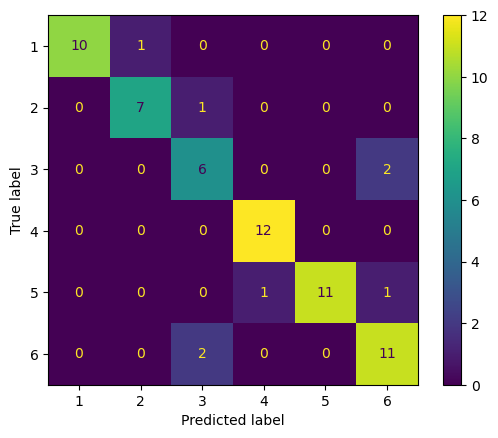

In [24]:
estimators.append(print_estimator_name(svc))
f1_macro.append(y)
accuracy.append(a)
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test) # Updated function call
plt.show()

In [25]:
estimators

['SVC']

**KNN Training**

In [26]:
dataset=temp2
features=dataset.drop(columns=["label","class"])
labels=dataset["class"]

C:\Users\owais\AppData\Local\Temp\ipykernel_32420\2486602179.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features=dataset.drop(columns=["label","class"])


In [27]:
X_train, X_test,y_train,y_test= train_test_split(features,labels,test_size=0.30, random_state=1)

In [28]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train -= mean
X_train /= std
X_test -= mean
X_test /= std

In [29]:
## Training KNN Classifier


knn=KNeighborsClassifier(metric='minkowski',algorithm= 'auto',n_neighbors=10,p=2,weights='distance',leaf_size=5)
knn.fit(X_train,y_train)


KNeighborsClassifier(leaf_size=5, n_neighbors=10, weights='distance')

In [38]:
# Predictions
y_test_pred = knn.predict(X_test)

# Metrics
y = f1_score(y_test, y_test_pred, average='macro')  # or 'weighted' if classes are imbalanced
x = confusion_matrix(y_test, y_test_pred)
a = accuracy_score(y_test, y_test_pred)

# Precision and Recall
precision = precision_score(y_test, y_test_pred, average='macro')  # 'micro' or 'weighted' as needed
recall = recall_score(y_test, y_test_pred, average='macro')

# Print results
print("F1 Score:", y)
print("Confusion Matrix:\n", x)
print("Accuracy:", a)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.834884801189149
Confusion Matrix:
 [[11  0  0  0  0  0]
 [ 0  7  1  0  0  0]
 [ 1  0  5  0  0  2]
 [ 0  0  0 12  0  0]
 [ 1  0  0  2 10  0]
 [ 0  1  2  0  0 10]]
Accuracy: 0.8461538461538461
Precision: 0.8394383394383395
Recall: 0.8397435897435898


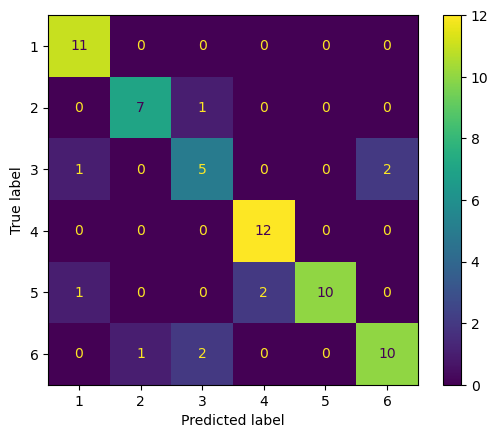

In [31]:
estimators.append(print_estimator_name(knn))
f1_macro.append(y)
accuracy.append(a)
ConfusionMatrixDisplay.from_estimator(knn,X_test,y_test) # Updated function call
plt.show()

In [33]:
estimators

['SVC', 'KNeighborsClassifier']

In [35]:
for i in np.arange(len(estimators)):
    f1_macro[i]=round(f1_macro[i],3)
    accuracy[i]=round(accuracy[i],3)

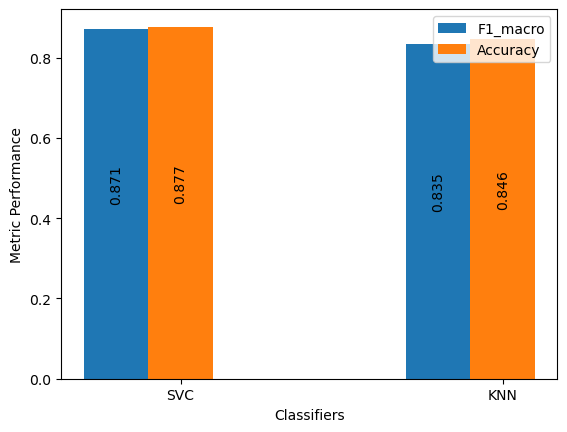

In [36]:
## plotting results of comparative study
estimators=['SVC','KNN']
# Remove duplicate entries in case the cells were run multiple times
estimators = list(dict.fromkeys(estimators))
f1_macro = f1_macro[:len(estimators)]
accuracy = accuracy[:len(estimators)]

fig, ax = plt.subplots()
width=0.2
bar_plot1 = ax.bar(np.arange(len(estimators)),f1_macro,width,tick_label=estimators)
bar_plot2 = ax.bar(np.arange(len(estimators))+width,accuracy,width,tick_label=estimators)

ax.set_xlabel('Classifiers')
ax.set_ylabel('Metric Performance')
ax.legend(('F1_macro','Accuracy'),loc='upper right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,height,ha='center', va='bottom', rotation=90)
autolabel(bar_plot1)
autolabel(bar_plot2)
plt.show()